# Data Analysis - Experiments

In [1]:
import os
import re
from typing import Dict, Tuple, List
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

## Constants

In [2]:
DATA_DIR = './data'

## Util functions

In [3]:
def parse_filename(filename: str) -> Tuple[str, int, int]:
    match = re.match(r"expectimax_([a-z_]+)_depth_(\d+)_([a-z]+)_size_(\d+)\.csv", filename)
    if match:
        heuristic, depth, board_type, size = match.groups()
        return heuristic, int(depth), int(size)
    match = re.match(r"random_([a-z]+)_size_(\d+)\.csv", filename)
    if match:
        board_type, size = match.groups()
        return 'random', 0, int(size)
    raise ValueError(f"Unrecognized filename: {filename}")

def load_datasets(data_dir: str) -> Dict[str, Dict[str, Dict[int, pd.DataFrame]]]:
    """
    Loads datasets into a nested dict: datasets[board_type][heuristic][depth] = DataFrame
    """
    datasets: Dict[str, Dict[str, Dict[int, pd.DataFrame]]] = {}
    for board_type in os.listdir(data_dir):
        board_path = os.path.join(data_dir, board_type)
        if not os.path.isdir(board_path):
            continue
        for fname in os.listdir(board_path):
            if not fname.endswith('.csv'):
                continue
            try:
                heuristic, depth, size = parse_filename(fname)
            except ValueError:
                continue
            if board_type not in datasets:
                datasets[board_type] = {}
            if heuristic not in datasets[board_type]:
                datasets[board_type][heuristic] = {}
            df = pd.read_csv(os.path.join(board_path, fname))
            datasets[board_type][heuristic][depth] = df
    return datasets


## Plot functions

To compare different heuristics for the same topology

In [4]:
def prepare_violin_plot_data(
    heuristics_dfs: Dict[str, Dict[int, pd.DataFrame]],
    metric: str,
    random_df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Prepare a DataFrame for violin plot with values of the specified metric
    for all heuristics and depths, including optional random baseline.
    """
    plot_data = []

    for heuristic, dfs in heuristics_dfs.items():
        if heuristic == 'random':
            continue
        for depth, df in dfs.items():
            vals = df[metric]
            if metric == 'max_tile':
                vals = np.log2(vals)
            for val in vals:
                plot_data.append({
                    'heuristic': heuristic,
                    'depth': depth,
                    'value': val,
                    'category': f'{heuristic}_d{depth}'
                })

    if random_df is not None:
        vals = random_df[metric]
        if metric == 'max_tile':
            vals = np.log2(vals)
        for val in vals:
            plot_data.append({
                'heuristic': 'random',
                'depth': 0,
                'value': val,
                'category': 'random'
            })

    return pd.DataFrame(plot_data)


def plot_metric_all_heuristics(
    plot_df: pd.DataFrame,
    board_type: str,
    heuristics_dfs: Dict[str, Dict[int, pd.DataFrame]],
    random_df: pd.DataFrame = None
) -> None:
    """
    Plot violin plots for the given metric using the prepared DataFrame,
    with comparisons between heuristics and an optional random baseline.
    """
    plt.figure(figsize=(14, 8))

    desired_order = ["random", "empty_cells", "snake"]
    heuristics = [h for h in desired_order if h in heuristics_dfs.keys() and h != 'random']
    all_depths = sorted(next((dfs for h, dfs in heuristics_dfs.items() if h != 'random'), None).keys())

    positions = []
    labels = []
    colors_list = []
    colors = plt.cm.get_cmap('Set1')
    pos = 0

    if random_df is not None:
        positions.append(pos)
        labels.append('random')
        colors_list.append('tab:red')
        pos += 1.5

    for heuristic_idx, heuristic in enumerate(heuristics):
        for depth in all_depths:
            positions.append(pos)
            labels.append(f'{heuristic}\nd{depth}')
            colors_list.append(colors(heuristic_idx + 1))
            pos += 1
        pos += 0.5

    violin_data = []

    if random_df is not None:
        random_data = plot_df[plot_df['heuristic'] == 'random']['value']
        violin_data.append(random_data.values)

    for heuristic in heuristics:
        for depth in all_depths:
            data = plot_df[(plot_df['heuristic'] == heuristic) & (plot_df['depth'] == depth)]['value']
            violin_data.append(data.values)

    parts = plt.violinplot(violin_data, positions=positions, widths=0.8, showmeans=False, showmedians=True)

    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors_list[i])
        pc.set_alpha(0.7)

    plt.xticks(positions, labels, rotation=45, ha='right')
    plt.xlabel('Models')
    plt.ylabel(f'log2(max_tile)')
    plt.title(f'Models performance - {board_type.upper()}')

    legend_elements = []
    if random_df is not None:
        legend_elements.append(plt.Line2D([0], [0], color='tab:red', lw=4, label='random'))
    for idx, heuristic in enumerate(heuristics):
        legend_elements.append(plt.Line2D([0], [0], color=colors(idx + 1), lw=4, label=heuristic))

    plt.legend(handles=legend_elements, loc='upper left', fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


To compare differents topologies

In [5]:
def plot_mean_log2_max_tile_per_topology(
    board_heuristics_dfs: Dict[str, Dict[str, Dict[int, pd.DataFrame]]]
) -> None:
    """
    Plota um gráfico de barras com a média e desvio padrão de log2(max_tile)
    para o modelo 'snake' na melhor profundidade para cada topologia.
    """
    board_means = {}
    board_stds = {}

    for board_type, heuristics_dfs in board_heuristics_dfs.items():
        if 'snake' not in heuristics_dfs:
            continue
        depths_dfs = heuristics_dfs['snake']
        if not depths_dfs:
            continue

        # Escolher a profundidade com maior média de log2(max_tile)
        best_depth = max(
            depths_dfs.keys(),
            key=lambda d: np.log2(depths_dfs[d]['max_tile']).mean()
        )

        df = depths_dfs[best_depth]
        log_max_tiles = np.log2(df['max_tile'])
        board_means[board_type] = log_max_tiles.mean()
        board_stds[board_type] = log_max_tiles.std()

    sorted_items = sorted(board_means.items(), key=lambda x: x[1])
    topologies = [item[0] for item in sorted_items]
    means = [board_means[topo] for topo in topologies]
    stds = [board_stds[topo] for topo in topologies]

    x = np.arange(len(topologies)) * 1.5
    bar_width = 0.8

    tab10 = plt.get_cmap('tab10').colors
    colors = [tab10[i % 10] for i in range(len(topologies))]

    plt.figure(figsize=(8, 5))
    plt.bar(x, means, yerr=stds, capsize=6, color=colors, alpha=0.9, width=bar_width)

    plt.xticks(x, topologies, fontsize=10)
    plt.ylabel('Mean log2(max_tile)')
    plt.xlabel('Board Topology')
    plt.title('Topologies performance - Comparison (Best Depth)')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/mean_log2_max_tile_per_topology.png')
    plt.show()

## Analysis

In [6]:
datasets = load_datasets(DATA_DIR)

Comparing different heuristics

C:\Users\luizg\AppData\Local\Temp\ipykernel_20048\1019254926.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')


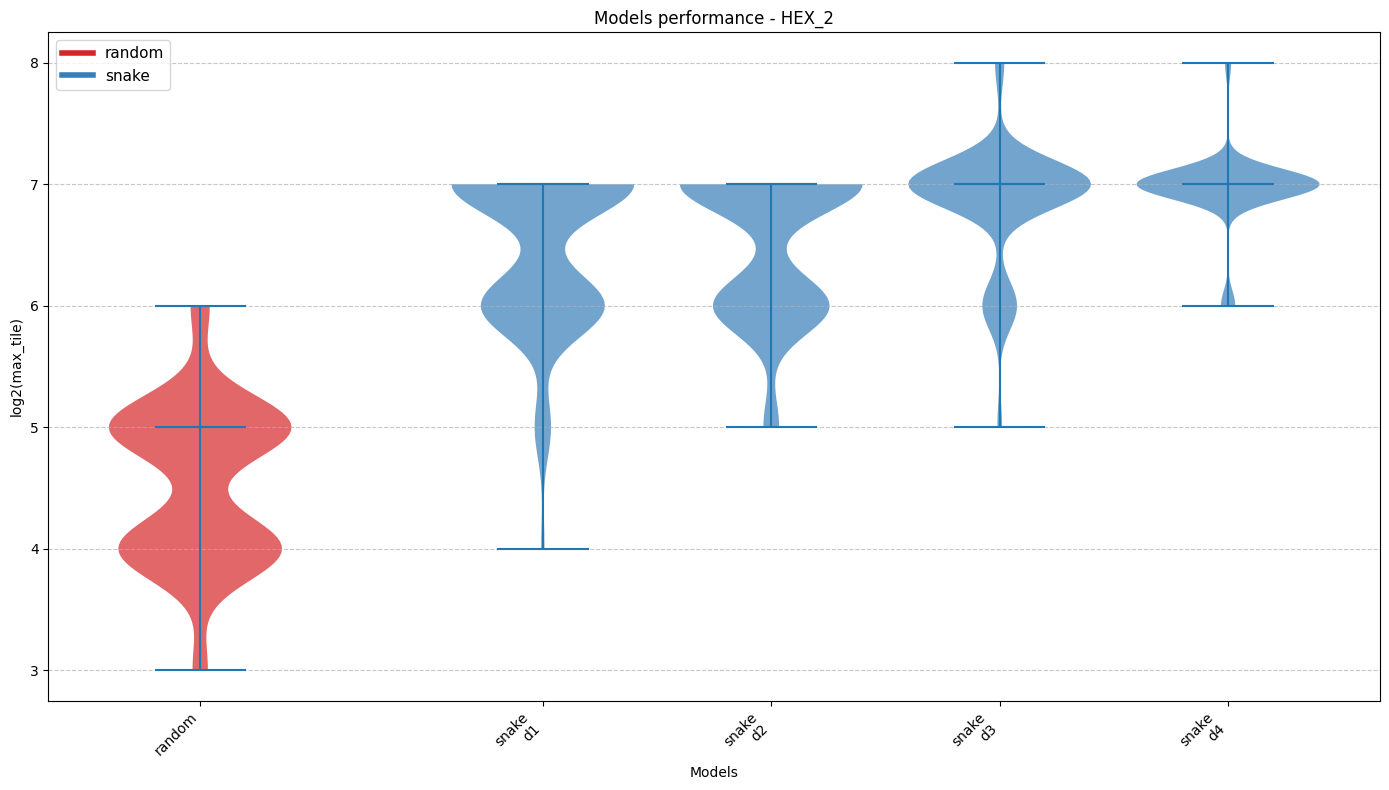

C:\Users\luizg\AppData\Local\Temp\ipykernel_20048\1019254926.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')


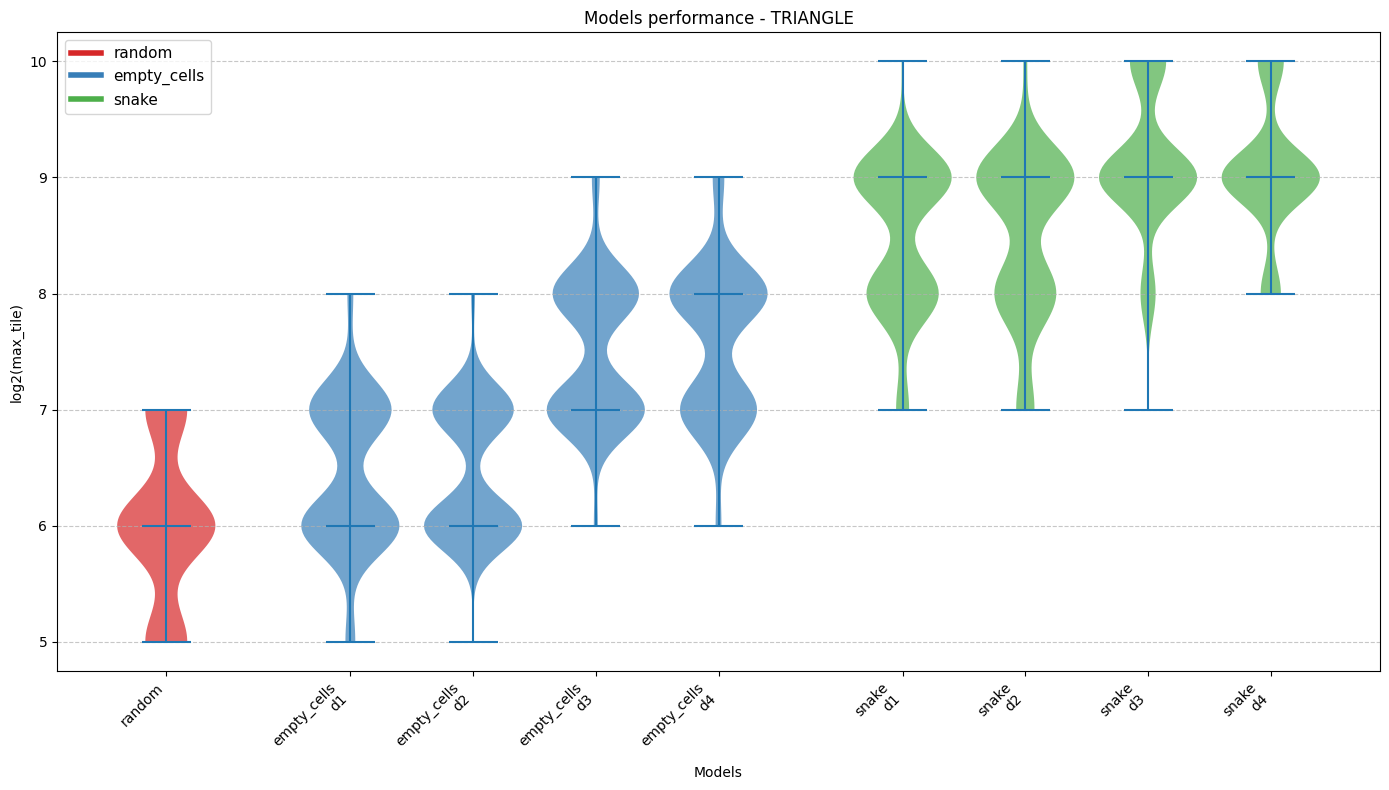

C:\Users\luizg\AppData\Local\Temp\ipykernel_20048\1019254926.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')


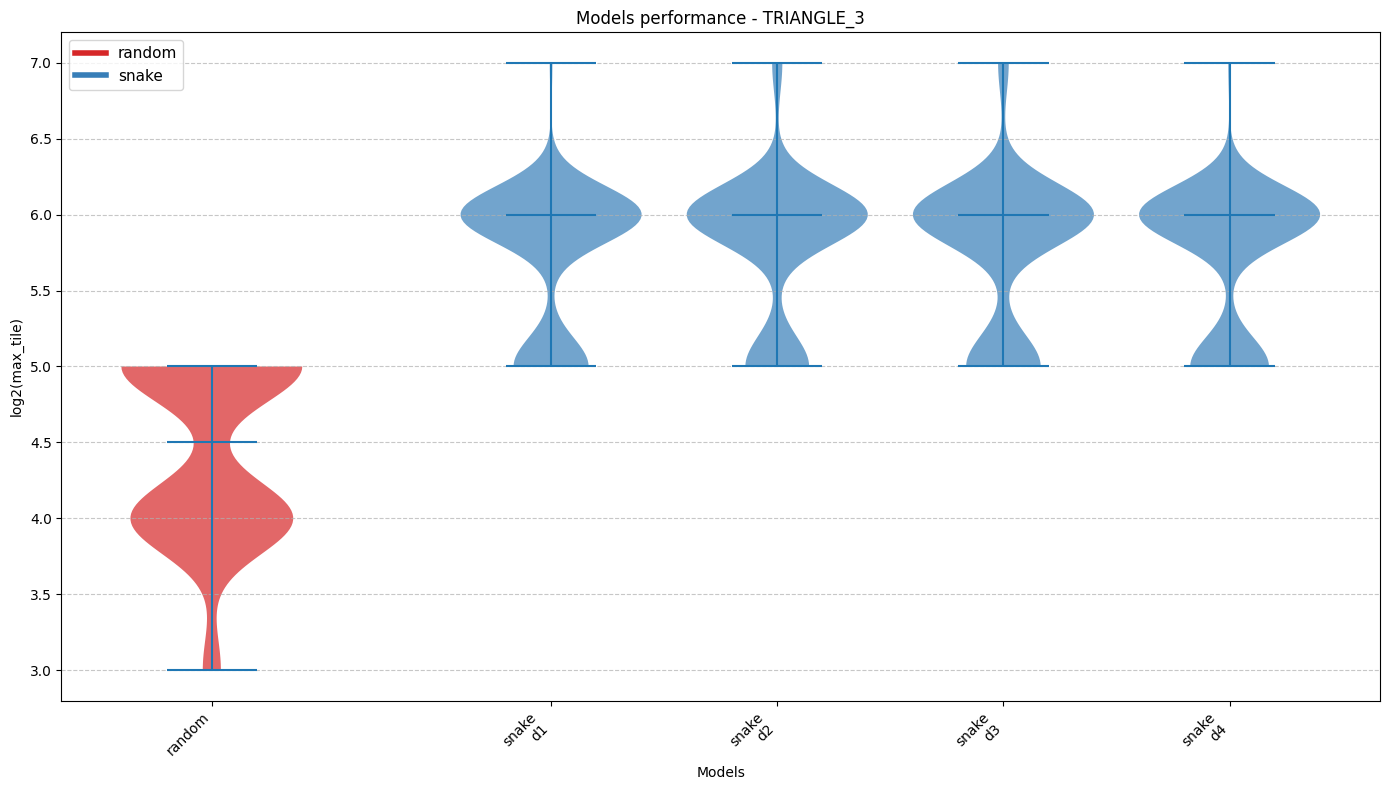

C:\Users\luizg\AppData\Local\Temp\ipykernel_20048\1019254926.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')


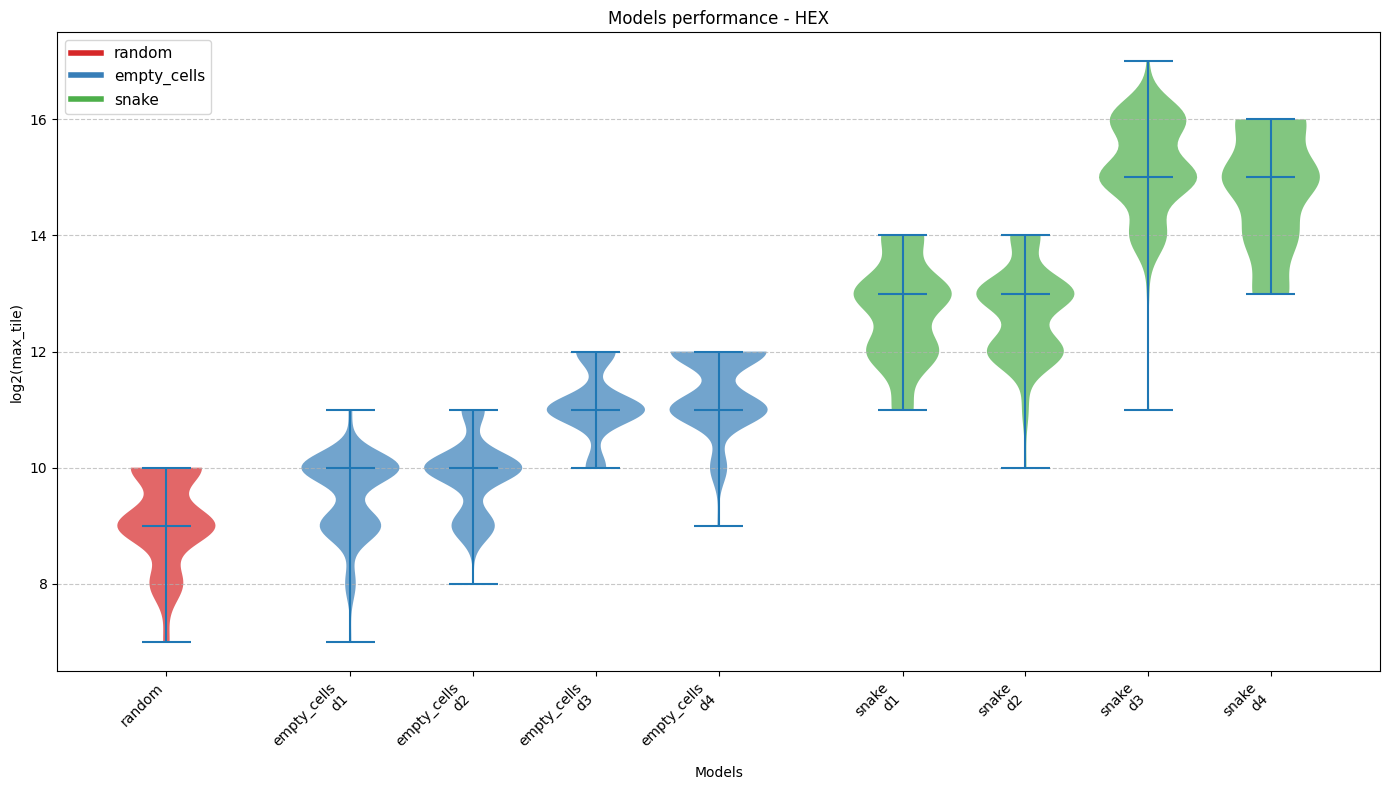

C:\Users\luizg\AppData\Local\Temp\ipykernel_20048\1019254926.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')


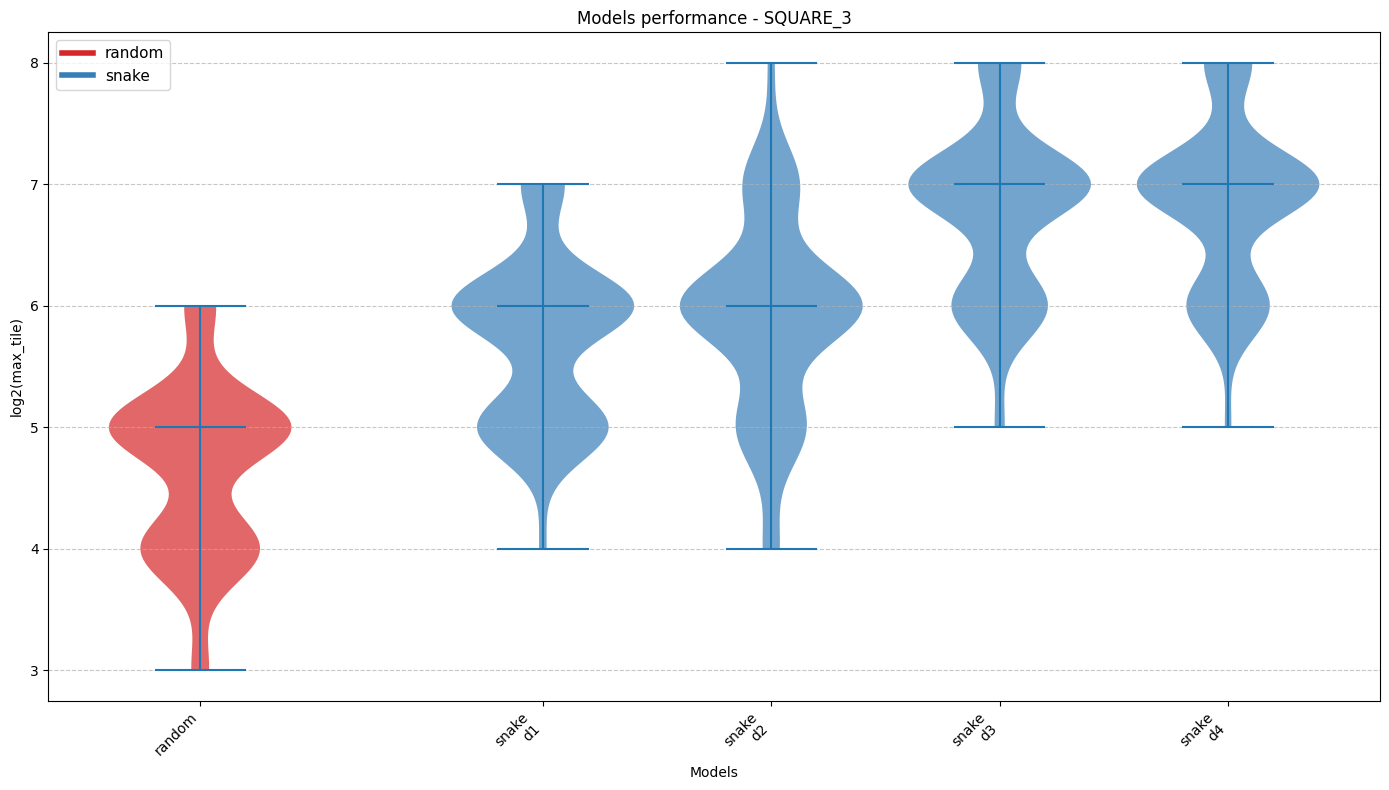

C:\Users\luizg\AppData\Local\Temp\ipykernel_20048\1019254926.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')


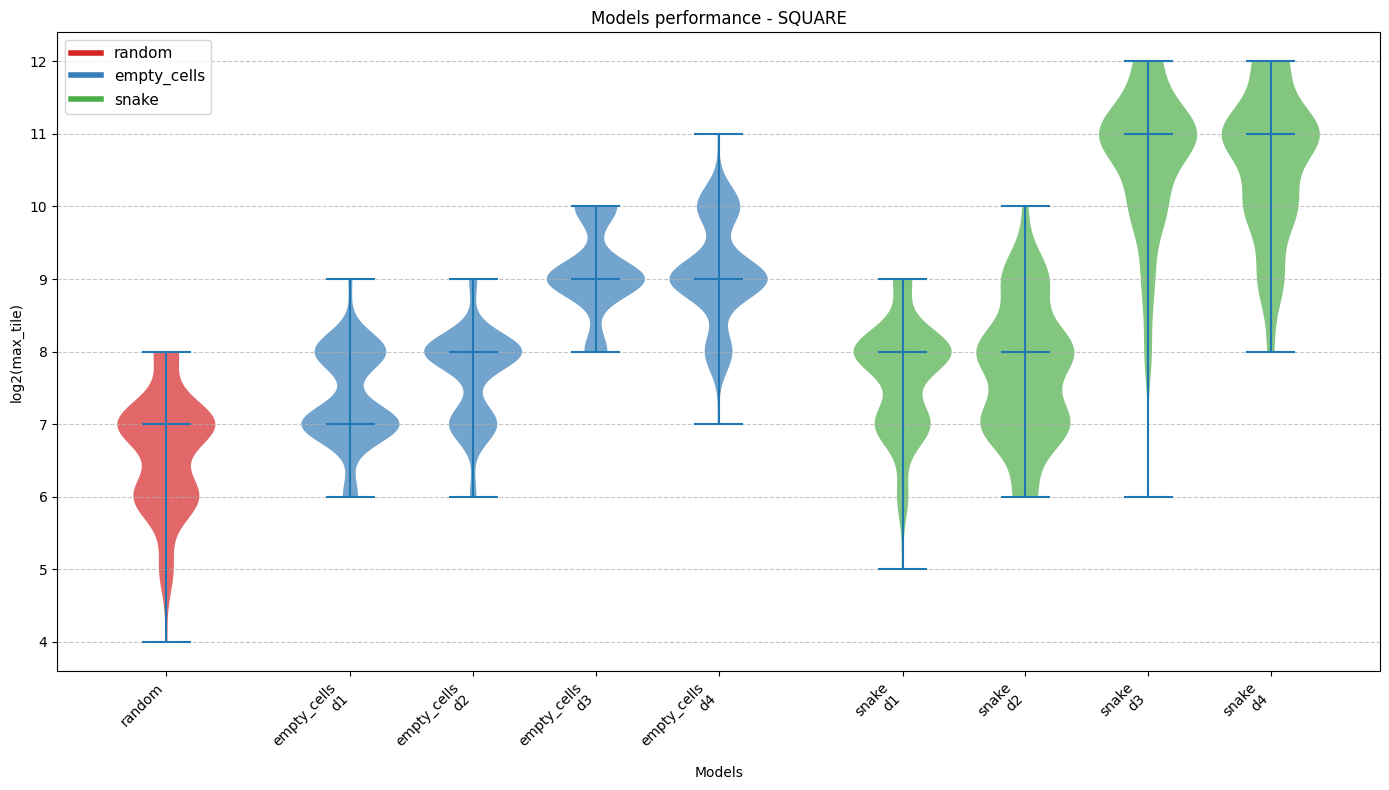

In [7]:
for board_type, heuristics in datasets.items():
    random_df = heuristics['random'][0] if 'random' in heuristics and 0 in heuristics['random'] else None
    plot_df = prepare_violin_plot_data(heuristics_dfs=heuristics, metric="max_tile", random_df=random_df)
    plot_metric_all_heuristics(
        plot_df=plot_df,
        heuristics_dfs=heuristics,
        board_type=board_type,
        random_df=random_df
    )

Comparing different topologies

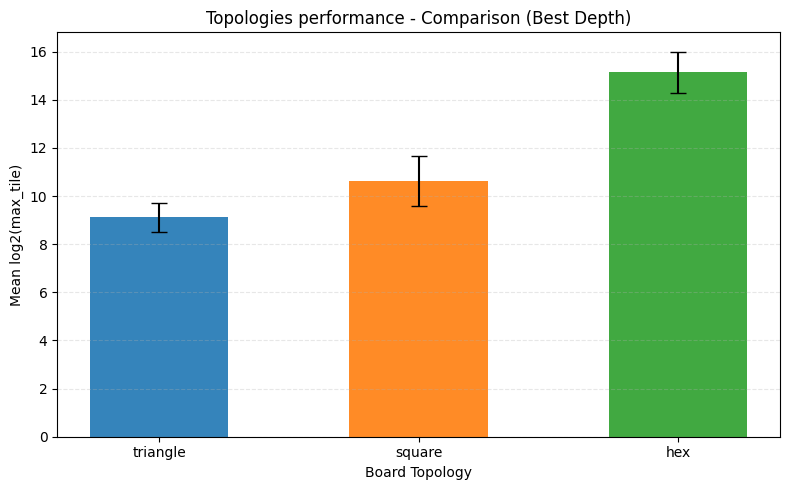

In [13]:
plot_mean_log2_max_tile_per_topology({k: v for k, v in datasets.items() if k in ['square', 'hex', 'triangle']})